# Ensemble-Averaging pMDI Spray Data

This program reads output of Step3 and averages multiple replicates of the same experiment with the same camera settings.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 08/11/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [18]:
import h5py, os, time, glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget

## Read all the data

In [19]:

prefix = '/Volumes/DUKE SSD ext4 2/2025_Oct_ConeAnglePlaceboStudy/90 & 120 degree/20kHz_896x920_134a_0.3Or08L_cone901.3Dep_MK6/'
wildcard_search = prefix+'20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S*/*.h5'
micron_per_pixel=31.
frame_rate=20000.

In [20]:
# Open all the files and get a handle to the relevant data in each.
# This will leave a lot of files open that ought to be properly closed later!
H=[]
data=[]
for filename in glob.glob(wildcard_search):
    print("Reading %s" % os.path.basename(filename))
    H.append(h5py.File(filename,'r'))
    if not 'spray_morphology' in H[-1]:
        raise IOError("\tstep 3 output is missing from file.")
    else:
        data.append(H[-1]['spray_morphology'])

Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0002.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0003.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0004.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0005.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0006.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0007.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0008.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0009.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0010.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0011.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0012.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0013.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0014.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0015.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0016.h5
Reading 

## Align data in time

In [21]:
def filterOutlier(w):
    flt=np.abs(w - np.nanmean(w))>3*np.nanstd(w)
    output=w[...]
    output[flt]=np.nan
    return output

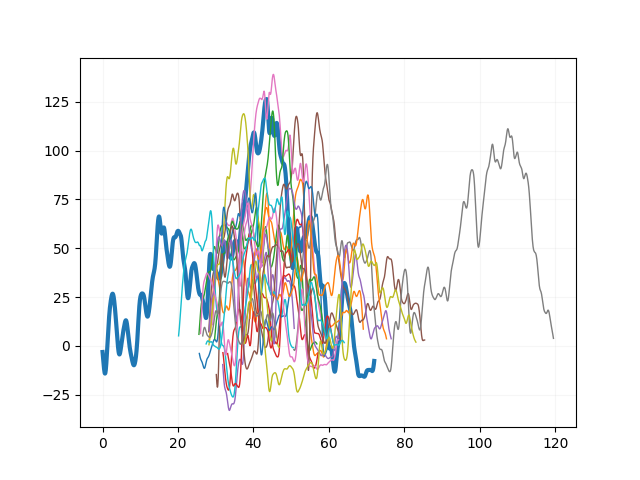

In [22]:
fig=plt.figure()
kernel=np.hanning(32); kernel /= np.sum(kernel)
dataRef=None
time_align=[]
for i in np.arange(len(data)):
    
    t0 = data[i].attrs['t0'] # Time offset from previous processing
    w=data[i]['widths'][...]*data[i]['coneAngleDeg'][...]      # metric for time alignment
    t_=np.arange(w.shape[0]) # Time axis for plot
    w=filterOutlier(w)
    streamwiseAverage=np.nanmean(w, axis=1) # Average in streamwise coordinate
    streamwiseAverage=np.convolve(streamwiseAverage, kernel, 'same') # smooth in time
    
    if dataRef is not None:
        cc=np.correlate(streamwiseAverage, dataRef, 'same')
        dt= np.where(np.nanmax(cc)==cc)[0][0]
        #print(dt*1e3/frame_rate)
        lw=1
    else:
        dt=0
        dataRef=streamwiseAverage
        lw=3

    time_align.append(dt)
    
    plt.plot((t_+dt)*1e3/frame_rate, streamwiseAverage *1e-3*micron_per_pixel,lw=lw)

plt.grid(alpha=.1);

## Filter data in time

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/1261874704.py:8: RuntimeWarning: Mean of empty slice
  mydata=np.convolve(np.nanmean(mydata,axis=1),kernel,'same') # spatial avg and smooth


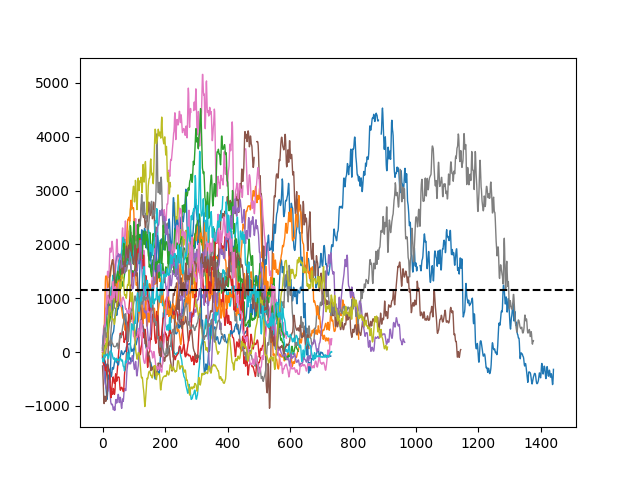

In [64]:
kernel=np.hanning(8); kernel /= np.sum(kernel)
fig=plt.figure()

all_data=[]
for i in np.arange(len(data)):
    mydata=data[i]['widths'][...]*data[i]['coneAngleDeg'][...]
    mydata=filterOutlier(mydata[:,100:-100]) # crop and filter
    mydata=np.convolve(np.nanmean(mydata,axis=1),kernel,'same') # spatial avg and smooth
    all_data.extend(np.ravel(mydata))
    t_=np.arange(mydata.shape[0])
    plt.plot(t_ ,mydata,lw=1);
    
temporal_threshold=np.abs( np.nanmean(np.array(all_data)) )
plt.axhline(temporal_threshold,ls='--',c='k');

temporal_filter=[]
for i in np.arange(len(data)):
    mydata=data[i]['widths'][...]*data[i]['coneAngleDeg'][...]
    temporal_filter.append(mydata>=temporal_threshold)

## Plot all the data

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/1104905780.py:34: RuntimeWarning: Mean of empty slice
  ax1.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['widths']), axis=0)[roi_x0:] *1e-3*micron_per_pixel)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/1104905780.py:37: RuntimeWarning: Mean of empty slice
  ax3.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['coneAngleDeg']), axis=0)[roi_x0:] )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/1104905780.py:40: RuntimeWarning: Mean of empty slice
  ax5.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['targetingAngleDeg']), axis=0)[roi_x0:] )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/1104905780.py:41: RuntimeWarning: Mean of empty slice
  ax6.scatter(t_*1e3/frame_rate, np.nanmean(filterOutlier(data[i]['targetingAngleDeg']), axis=1), 1)


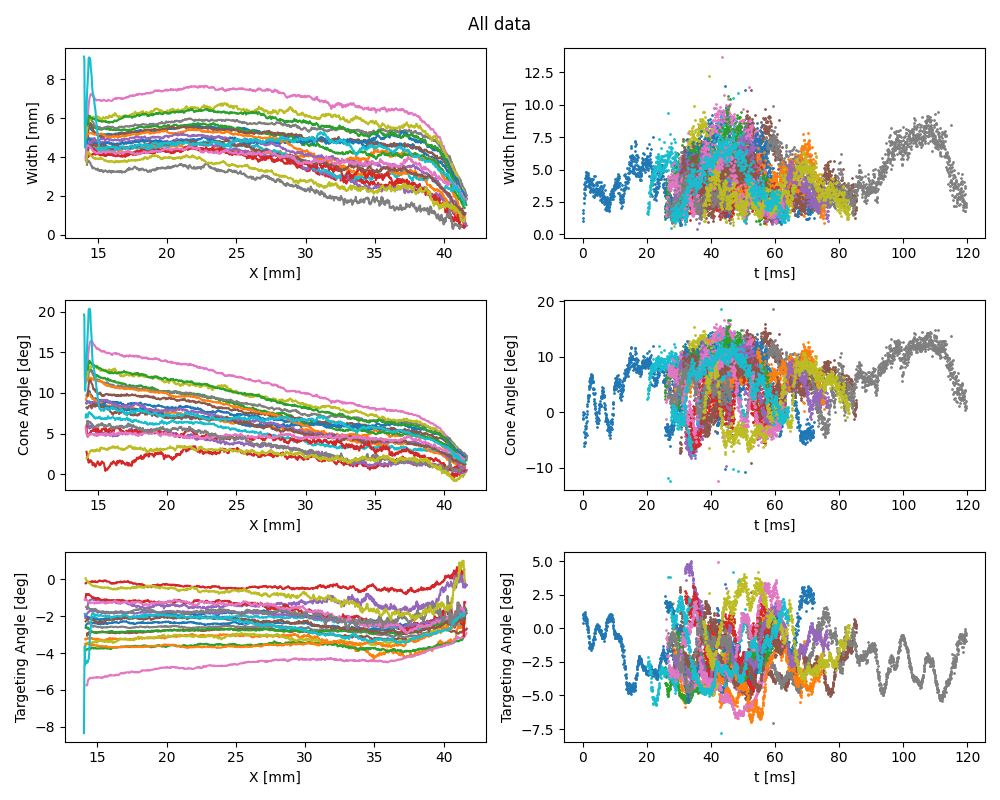

In [44]:
fig=plt.figure(figsize=(10,8))

ax1=fig.add_subplot(321)
plt.xlabel('X [mm]'); plt.ylabel('Width [mm]')

ax2=fig.add_subplot(322)
plt.xlabel('t [ms]'); plt.ylabel('Width [mm]')

ax3=fig.add_subplot(323)
plt.xlabel('X [mm]'); plt.ylabel('Cone Angle [deg]')

ax4=fig.add_subplot(324)
plt.xlabel('t [ms]'); plt.ylabel('Cone Angle [deg]')

ax5=fig.add_subplot(325)
plt.xlabel('X [mm]'); plt.ylabel('Targeting Angle [deg]')

ax6=fig.add_subplot(326)
plt.xlabel('t [ms]'); plt.ylabel('Targeting Angle [deg]')


for i in range(len(data)):
    #t0 = data[i].attrs['t0'] # Time offset data
    
    # Origin data for alignment of X and Y axes.
    x0 = data[i].attrs['actuator_origin_x0'];
    y0 = data[i].attrs['actuator_origin_y0']
    roi_x0 = int(data[i].attrs['roi_x0']) + 2 # start plotting 2px after mouthpiece

    dt = time_align[i]
    t_=np.arange(data[i]['widths'].shape[0]) + dt 
    x_=np.arange(data[i]['widths'].shape[1])+y0

    ax1.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['widths']), axis=0)[roi_x0:] *1e-3*micron_per_pixel)
    ax2.scatter(t_*1e3/frame_rate, np.nanmean(filterOutlier(data[i]['widths']), axis=1) *1e-3*micron_per_pixel, 1)

    ax3.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['coneAngleDeg']), axis=0)[roi_x0:] )
    ax4.scatter(t_*1e3/frame_rate, np.nanmean(filterOutlier(data[i]['coneAngleDeg']), axis=1), 1)

    ax5.plot(x_[roi_x0:]*1e-3*micron_per_pixel,  np.nanmean(filterOutlier(data[i]['targetingAngleDeg']), axis=0)[roi_x0:] )
    ax6.scatter(t_*1e3/frame_rate, np.nanmean(filterOutlier(data[i]['targetingAngleDeg']), axis=1), 1)

plt.suptitle("All data");
plt.tight_layout();

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/3252777625.py:45: RuntimeWarning: Mean of empty slice
  ensemble_avg[j] = np.nanmean(d[j], axis=0)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/3252777625.py:46: RuntimeWarning: Mean of empty slice
  ensemble_sqr[j] = np.nanmean(d[j]**2, axis=0)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/3252777625.py:54: RuntimeWarning: Mean of empty slice
  ax.plot(xs,  np.nanmean(d[j], axis=0), c='gray',lw=0.5)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/3252777625.py:49: RuntimeWarning: Mean of empty slice
  ensemble_avg[j] += np.interp(ensemble_x, xs, np.nanmean(d[j], axis=0))
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_7217/3252777625.py:50: RuntimeWarning: Mean of empty slice
  ensemble_sqr[j] += np.interp(ensemble_x, xs, np.nanmean(d[j]**2, axis=0))


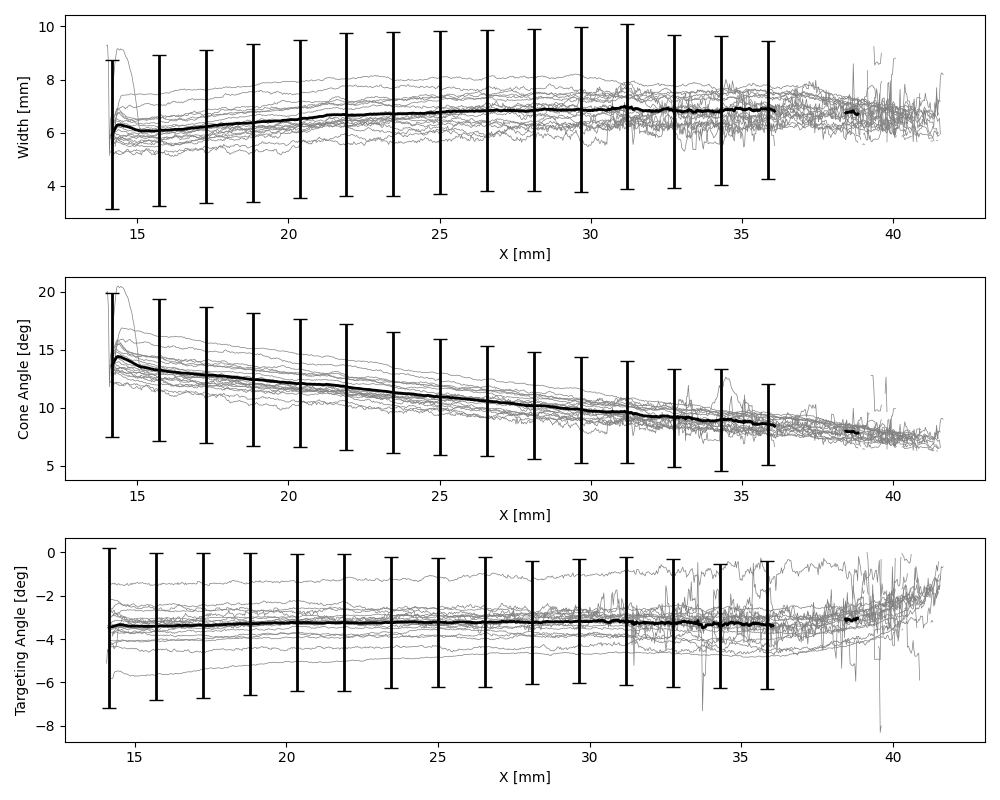

In [71]:
fig=plt.figure(figsize=(10,8))

ax1=fig.add_subplot(311)
plt.xlabel('X [mm]'); plt.ylabel('Width [mm]')

ax2=fig.add_subplot(312)
plt.xlabel('X [mm]'); plt.ylabel('Cone Angle [deg]')

ax3=fig.add_subplot(313)
plt.xlabel('X [mm]'); plt.ylabel('Targeting Angle [deg]')

ensemble_avg = [[],[],[]]
ensemble_sqr = [[],[],[]]
temporal_std = [[],[],[]]
ensemble_x = None

N = len(data)

for i in range(N):
    # Time offset data
    #t0 = data[i].attrs['t0']
    
    # Origin data for alignment of X and Y axes.
    x0 = data[i].attrs['actuator_origin_x0']
    y0 = data[i].attrs['actuator_origin_y0']
    roi_x0 = int(data[i].attrs['roi_x0']) + 2 # start plotting 2px after mouthpiece

    t_=np.arange(data[i]['widths'].shape[0]) + dt 
    x_=np.arange(data[i]['widths'].shape[1]) + y0
    
    d = [[],[],[]]
    d[0] = filterOutlier(data[i]['widths'][:,roi_x0:]) *1e-3*micron_per_pixel
    d[1] = filterOutlier(data[i]['coneAngleDeg'][:,roi_x0:])
    d[2] = filterOutlier(data[i]['targetingAngleDeg'][:,roi_x0:])
    xs = x_[roi_x0:]*1e-3*micron_per_pixel

    # Temporal filter
    for j in range(3):
        d[j][~temporal_filter[i][:,roi_x0:]] = np.nan

    # Temporal average
    if ensemble_x is None: 
        for j in range(3): # loop vars
            ensemble_x = xs[:]
            ensemble_avg[j] = np.nanmean(d[j], axis=0)
            ensemble_sqr[j] = np.nanmean(d[j]**2, axis=0)
    else:
        for j in range(3): # loop vars
            ensemble_avg[j] += np.interp(ensemble_x, xs, np.nanmean(d[j], axis=0))
            ensemble_sqr[j] += np.interp(ensemble_x, xs, np.nanmean(d[j]**2, axis=0))
            
    # Plot temporal averages
    for ax, j in zip((ax1,ax2,ax3),range(3)):
        ax.plot(xs,  np.nanmean(d[j], axis=0), c='gray',lw=0.5)
    

skip=50

for ax, j in zip((ax1,ax2,ax3),range(3)):
    ensemble_average_result = ensemble_avg[j]/float(N)
    ensemble_stddev_result = np.sqrt(ensemble_sqr[j]/float(N) - ensemble_average_result**2)
    
    ax.plot(ensemble_x, ensemble_average_result, c='k', lw=2)
    ax.errorbar(ensemble_x[::skip], ensemble_average_result[::skip],\
                 yerr=2*ensemble_stddev_result[::skip], c='k', capsize=5, lw=2, ls='None')

plt.tight_layout();

In [72]:
# Close out all files.
for H_ in H: H_.close()